# Máquina de Soporte Vectorial

In [1]:
!pip install -U imbalanced-learn


1: Importación de librerías

In [2]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings

# Ignorar todos los warnings
warnings.filterwarnings("ignore")


In [3]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.pipeline import make_pipeline
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score


2: Carga de datos y separación

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar los datos
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")

# Separar variables y target
X = df.drop(columns=["incumplimiento_credito"])
y = df["incumplimiento_credito"]

# Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Preprocesamiento

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Columnas categóricas y numéricas
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocesador
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


# Pipelines

In [6]:
# Capa RBF
rbf_feature = RBFSampler(gamma=1, n_components=300, random_state=42)

# Modelos base
sgd_svm = SGDClassifier(loss='hinge', random_state=42)
linear_svc = LinearSVC(max_iter=20000, random_state=42)

# Técnicas de balanceo
balanceadores = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'class_weight': None
}

# Guardar todos los pipelines
pipelines = {}

for bal_name, sampler in balanceadores.items():
    for model_name, clf in [('SGD_RFF', sgd_svm), ('LinearSVC_RFF', linear_svc)]:
        key = f"{model_name}_{bal_name}"

        if bal_name == 'class_weight':
            clf.set_params(class_weight='balanced')
            pipe = ImbPipeline([
                ('preprocessor', preprocessor),
                ('rbf', rbf_feature),
                ('clf', clf)  # este es el bueno
            ])
        else:
            clf.set_params(class_weight=None)
            pipe = ImbPipeline([
                ('preprocessor', preprocessor),
                ('rbf', rbf_feature),
                ('sampler', sampler),
                ('clf', clf)
            ])

        pipelines[key] = pipe


5: Entrenamiento, predicción y evaluación

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore", category=ConvergenceWarning)


results = []

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

final_step_name = pipe.steps[-1][0]
final_estimator = pipe.named_steps[final_step_name]

if isinstance(final_estimator, SGDClassifier):
    param_grid = {
        f"{final_step_name}__alpha": [0.0001, 0.001, 0.01, 0.1],
        f"{final_step_name}__penalty": ["l2", "elasticnet"],
        f"{final_step_name}__l1_ratio": [0.15, 0.3, 0.5],
        f"{final_step_name}__learning_rate": ["optimal", "adaptive"],
        f"{final_step_name}__eta0": [0.001, 0.01],
        f"{final_step_name}__early_stopping": [True],
        f"{final_step_name}__n_iter_no_change": [5],
        f"{final_step_name}__validation_fraction": [0.1],
        f"{final_step_name}__max_iter": [1000, 2000]
    }

elif isinstance(final_estimator, LinearSVC):
    param_grid = {
        f"{final_step_name}__C": [0.01, 0.1, 1, 10],
        f"{final_step_name}__tol": [1e-3, 1e-4],
        f"{final_step_name}__dual": [True, False],
        f"{final_step_name}__max_iter": [2000, 3000]
    }

else:
    raise ValueError(f"Modelo no reconocido: {type(final_estimator)}")




# Entrenamiento y optimización con detección automática del paso final
for name, pipe in pipelines.items():
    print(f"🔍 Optimizando y entrenando → {name}")
    t0 = time.time()

    # Detectar el nombre del paso final real (último en el pipeline)
    final_step_name = pipe.steps[-1][0]
    print(f"➡️ Paso final: {final_step_name}")

    # Hiperparámetros según tipo de modelo
    if "SGD" in name:
        param_grid = {
            f"{final_step_name}__alpha": [0.0001, 0.001, 0.01, 0.1],
            f"{final_step_name}__penalty": ["l2", "elasticnet"],
            f"{final_step_name}__l1_ratio": [0.15, 0.3, 0.5],
            f"{final_step_name}__learning_rate": ["optimal", "adaptive"],
            f"{final_step_name}__eta0": [0.001, 0.01],
            f"{final_step_name}__early_stopping": [True],
            f"{final_step_name}__n_iter_no_change": [5],
            f"{final_step_name}__validation_fraction": [0.1],
            f"{final_step_name}__max_iter": [1000, 2000]
        }
    else:
        param_grid = {
            f"{final_step_name}__C": [0.01, 0.1, 1, 10],
            f"{final_step_name}__tol": [1e-3, 1e-4],
            f"{final_step_name}__dual": [True, False],
            f"{final_step_name}__max_iter": [2000, 3000]
        }

    # GridSearchCV
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="recall",
        cv=3,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    fit_time = (time.time() - t0) / 60

    best_model = grid.best_estimator_

    # Guardar modelo entrenado para visualizaciones posteriores
    if 'modelos_entrenados' not in globals():
        modelos_entrenados = {}
    modelos_entrenados[name] = best_model

    # Predicciones y métricas
    y_pred = best_model.predict(X_test)

    try:
        y_prob = best_model.predict_proba(X_test)[:, 1]
    except:
        try:
            y_prob = best_model.decision_function(X_test)
        except:
            y_prob = y_pred

    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = np.nan

    results.append({
        "Modelo": name,
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall1": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": auc,
        "Tiempo (min)": fit_time,
        "Mejor Parámetro": grid.best_params_
    })


🔍 Optimizando y entrenando → SGD_RFF_SMOTE
➡️ Paso final: clf
🔍 Optimizando y entrenando → LinearSVC_RFF_SMOTE
➡️ Paso final: clf
🔍 Optimizando y entrenando → SGD_RFF_ADASYN
➡️ Paso final: clf
🔍 Optimizando y entrenando → LinearSVC_RFF_ADASYN
➡️ Paso final: clf
🔍 Optimizando y entrenando → SGD_RFF_class_weight
➡️ Paso final: clf
🔍 Optimizando y entrenando → LinearSVC_RFF_class_weight
➡️ Paso final: clf


In [8]:
df_resultados = pd.DataFrame(results)
df_resultados = df_resultados.sort_values(by="Recall1", ascending=False)

In [9]:
# Asegúrate de tener pandas importado
import pandas as pd

# Si ya tienes df_resultados, formatea y colorea:
df_resultados_styled = (
    df_resultados.style
    .format({
        "Precision": "{:.4f}",
        "Recall1": "{:.4f}",
        "Accuracy": "{:.4f}",
        "F1": "{:.4f}",
        "AUC": "{:.4f}",
        "Tiempo (min)": "{:.4f}"
    })
    .background_gradient(subset=["Precision"], cmap="YlOrBr")
    .background_gradient(subset=["Recall1"], cmap="Reds")
    .background_gradient(subset=["Accuracy"], cmap="Oranges")
    .background_gradient(subset=["F1"], cmap="Greens")
    .background_gradient(subset=["AUC"], cmap="Purples")
    .background_gradient(subset=["Tiempo (min)"], cmap="Blues")
)

# Mostrar tabla con estilos
display(df_resultados_styled)


,Modelo,Precision,Recall1,F1,Accuracy,AUC,Tiempo (min),Mejor Parámetro
0,SGD_RFF_SMOTE,0.0855,1.0000,0.1575,0.0855,0.5000,3.6835,"{'clf__alpha': 0.01, 'clf__early_stopping': True, 'clf__eta0': 0.001, 'clf__l1_ratio': 0.3, 'clf__learning_rate': 'adaptive', 'clf__max_iter': 1000, 'clf__n_iter_no_change': 5, 'clf__penalty': 'elasticnet', 'clf__validation_fraction': 0.1}"
4,SGD_RFF_class_weight,0.0857,0.6950,0.1525,0.3399,0.5006,1.9115,"{'clf__alpha': 0.01, 'clf__early_stopping': True, 'clf__eta0': 0.01, 'clf__l1_ratio': 0.15, 'clf__learning_rate': 'adaptive', 'clf__max_iter': 1000, 'clf__n_iter_no_change': 5, 'clf__penalty': 'l2', 'clf__validation_fraction': 0.1}"
5,LinearSVC_RFF_class_weight,0.0876,0.4713,0.1477,0.5352,0.5014,4.3679,"{'clf__C': 10, 'clf__dual': True, 'clf__max_iter': 2000, 'clf__tol': 0.0001}"
3,LinearSVC_RFF_ADASYN,0.0873,0.4556,0.1465,0.5461,0.5048,2.0657,"{'clf__C': 0.1, 'clf__dual': True, 'clf__max_iter': 2000, 'clf__tol': 0.001}"
1,LinearSVC_RFF_SMOTE,0.0843,0.4385,0.1415,0.5451,0.5043,1.4634,"{'clf__C': 0.1, 'clf__dual': True, 'clf__max_iter': 2000, 'clf__tol': 0.001}"
2,SGD_RFF_ADASYN,0.0000,0.0000,0.0000,0.9145,0.5000,6.1008,"{'clf__alpha': 0.01, 'clf__early_stopping': True, 'clf__eta0': 0.001, 'clf__l1_ratio': 0.15, 'clf__learning_rate': 'optimal', 'clf__max_iter': 1000, 'clf__n_iter_no_change': 5, 'clf__penalty': 'elasticnet', 'clf__validation_fraction': 0.1}"


In [10]:
y_pred = modelos_entrenados["SGD_RFF_ADASYN"].predict(X_test)
print("Predicciones únicas:", np.unique(y_pred, return_counts=True))


Predicciones únicas: (array([0], dtype=int64), array([15689], dtype=int64))


Boxplot

In [11]:
# Convertir a formato largo (melt)
df_long = df_resultados.melt(
    id_vars="Modelo",
    value_vars=["Precision", "Recall1", "F1", "AUC"],
    var_name="Métrica",
    value_name="Valor"
)

# (Opcional) Extraer el tipo de modelo para agrupar (SGD o LinearSVC)
df_long["Algoritmo"] = df_long["Modelo"].apply(lambda x: x.split("_")[0])


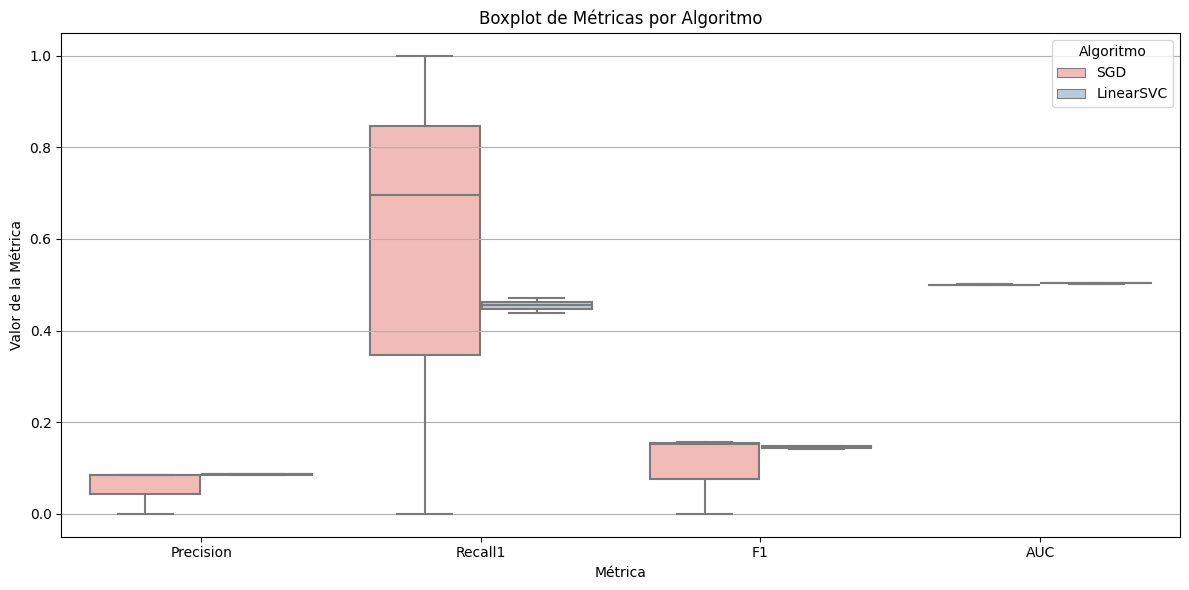

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sns.boxplot(data=df_long, x="Métrica", y="Valor", hue="Algoritmo", palette="Pastel1")

plt.title("Boxplot de Métricas por Algoritmo")
plt.ylabel("Valor de la Métrica")
plt.xlabel("Métrica")
plt.grid(True, axis='y')
plt.legend(title="Algoritmo")
plt.tight_layout()
plt.show()


# Matrices de Confusión Comparativas

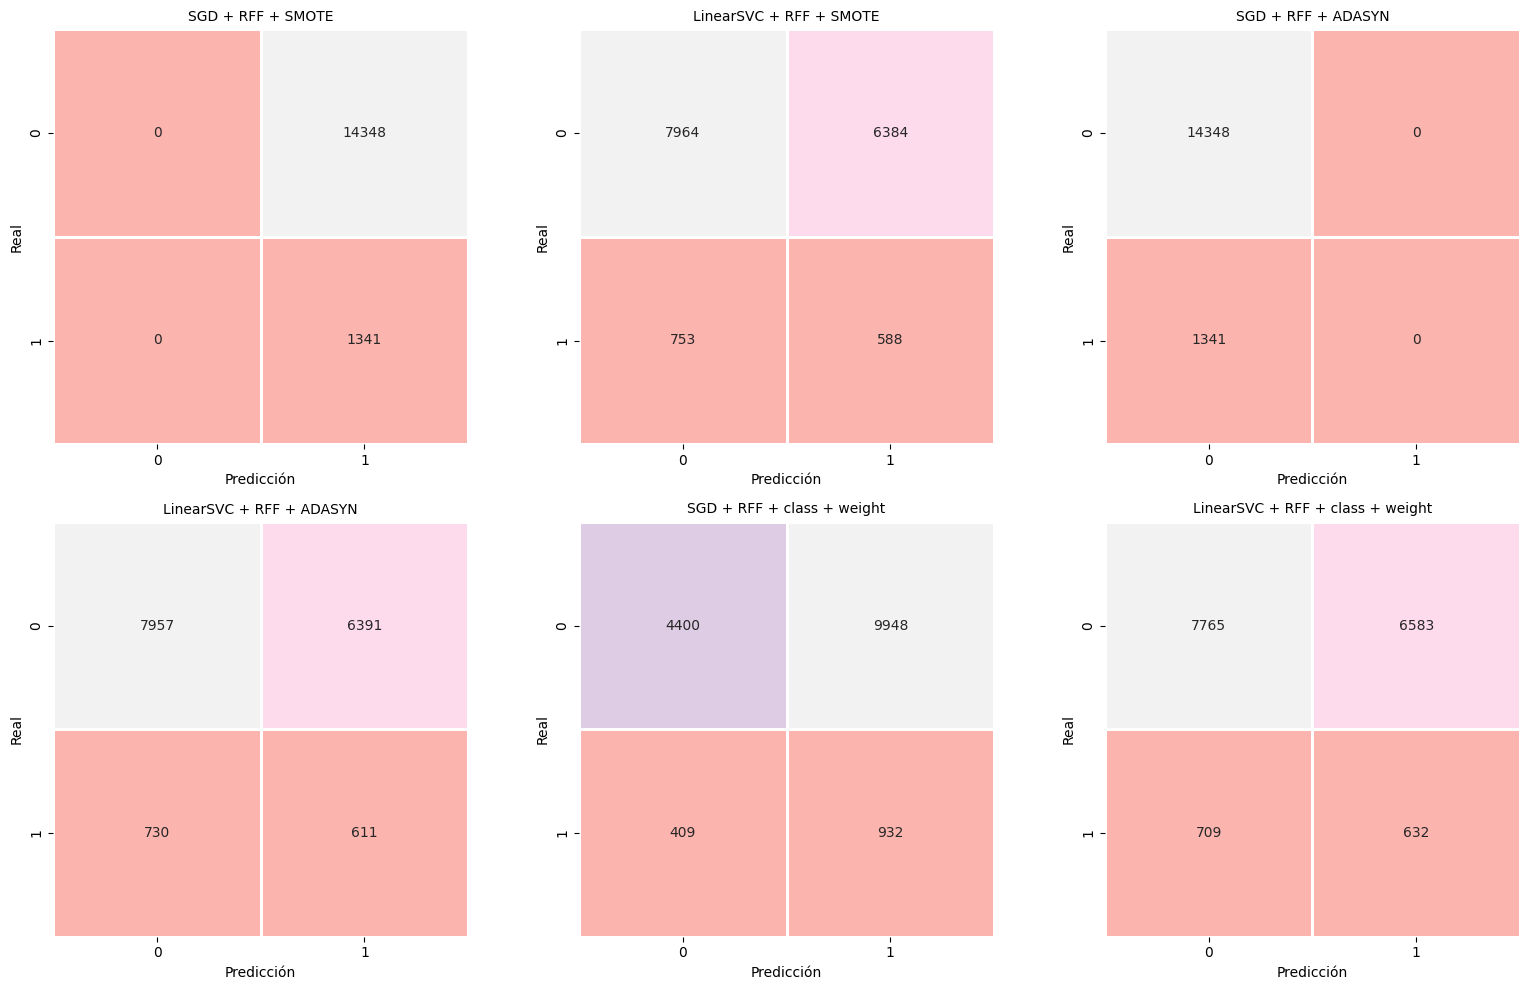

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(nrows=int(np.ceil(len(modelos_entrenados)/3)),
                         ncols=3,
                         figsize=(16, 10))

axes = axes.flatten()

for i, (nombre_modelo, modelo) in enumerate(modelos_entrenados.items()):
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Pastel1", ax=axes[i],
                cbar=False, linewidths=1, linecolor='white', square=True)

    axes[i].set_title(nombre_modelo.replace("_", " + "), fontsize=10)
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")

# Ocultar ejes vacíos si hay menos de 3xN
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Curvas ROC comparativas

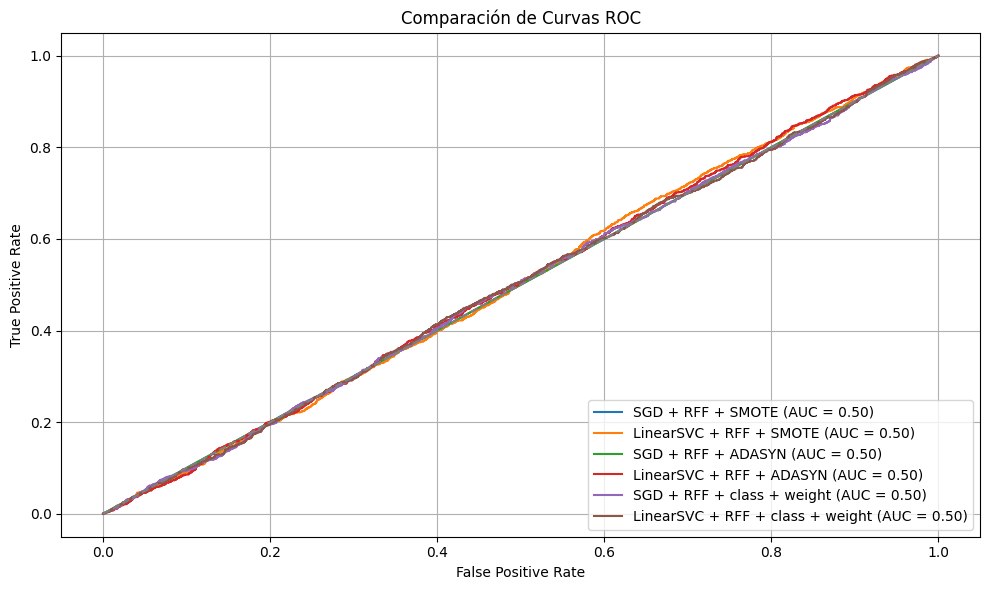

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

for nombre_modelo, modelo in modelos_entrenados.items():

    try:
        # Probabilidad estimada (si disponible)
        y_prob = modelo.predict_proba(X_test)[:, 1]
    except:
        # Si el modelo no tiene predict_proba, usar decision_function
        try:
            y_prob = modelo.decision_function(X_test)
        except:
            # Si no tiene ninguno, omitir modelo
            print(f"⚠️ El modelo {nombre_modelo} no tiene probabilidades.")
            continue

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    # Formatear nombre para el gráfico
    nombre_limpio = nombre_modelo.replace("_", " + ")
    plt.plot(fpr, tpr, label=f"{nombre_limpio} (AUC = {auc_score:.2f})")

# Línea de referencia (azar)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Personalización
plt.title("Comparación de Curvas ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


#  curvas Precision-Recall comparativas

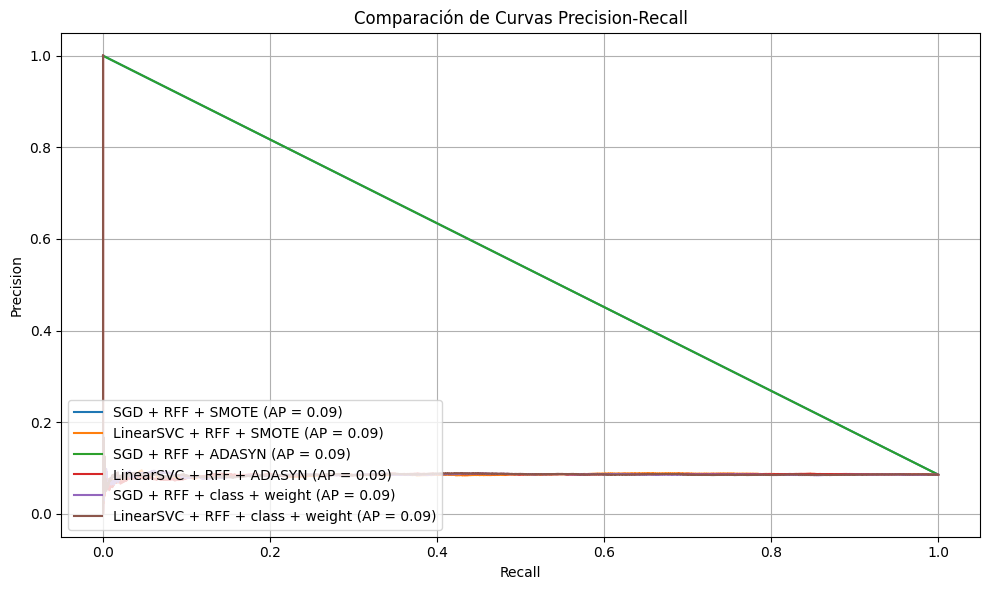

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for nombre_modelo, modelo in modelos_entrenados.items():

    try:
        # Obtener probabilidades
        y_prob = modelo.predict_proba(X_test)[:, 1]
    except:
        try:
            y_prob = modelo.decision_function(X_test)
        except:
            print(f"⚠️ El modelo {nombre_modelo} no tiene salida continua.")
            continue

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    nombre_limpio = nombre_modelo.replace("_", " + ")

    plt.plot(recall, precision, label=f"{nombre_limpio} (AP = {ap:.2f})")

# Formato del gráfico
plt.title("Comparación de Curvas Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()


Crear el boxplot por métrica agrupado por algoritmo

In [16]:
# Extraer tipo de modelo (SGD o LinearSVC) desde el nombre
df_resultados["Algoritmo"] = df_resultados["Modelo"].apply(lambda x: x.split("_")[0])


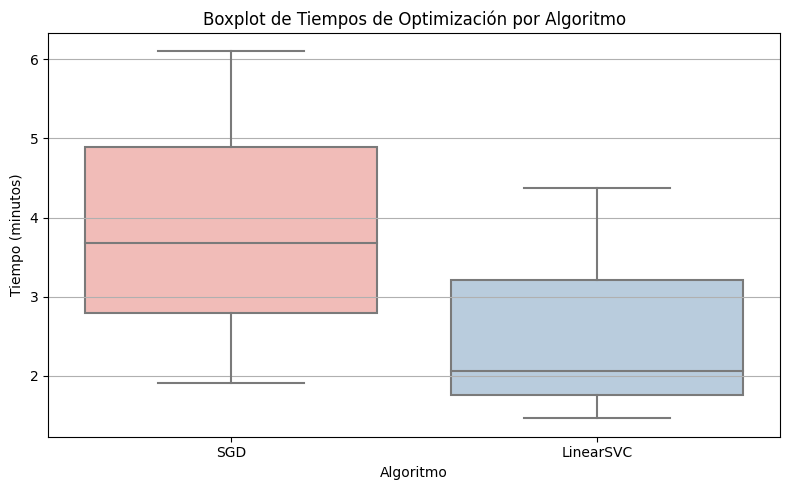

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

sns.boxplot(data=df_resultados, x="Algoritmo", y="Tiempo (min)", palette="Pastel1")

plt.title("Boxplot de Tiempos de Optimización por Algoritmo")
plt.ylabel("Tiempo (minutos)")
plt.xlabel("Algoritmo")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


CÓDIGO PARA BOXPLOT DE TIEMPO DE OPTIMIZACIÓN POR MODELO

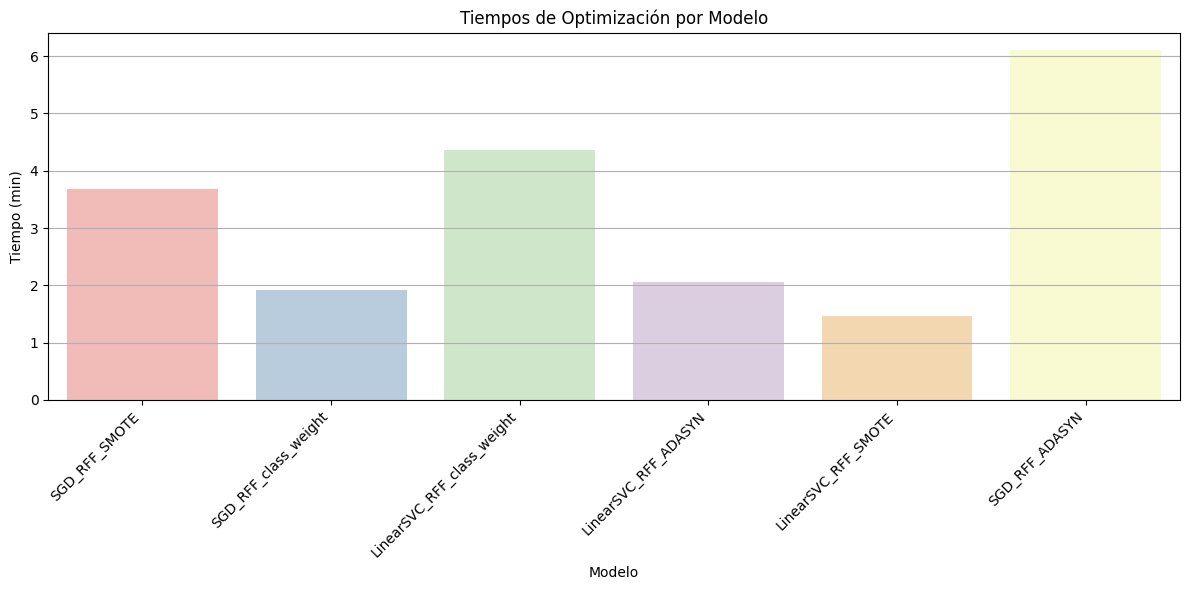

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Barplot de tiempo de optimización por modelo
sns.barplot(
    data=df_resultados,
    x="Modelo",
    y="Tiempo (min)",
    palette="Pastel1"
)

# Rotar etiquetas si hay muchas
plt.xticks(rotation=45, ha='right')

# Títulos y etiquetas
plt.title("Tiempos de Optimización por Modelo")
plt.ylabel("Tiempo (min)")
plt.xlabel("Modelo")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Barplot falsos positivos y falsos negativos

In [19]:
from sklearn.metrics import confusion_matrix

# Inicializar lista de resultados
fp_fn_data = []

for nombre_modelo, modelo in modelos_entrenados.items():

    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fp_fn_data.append({
        "Modelo": nombre_modelo.replace("_", " + "),
        "Falsos Positivos": fp,
        "Falsos Negativos": fn
    })

# Convertir a DataFrame
df_fpfn = pd.DataFrame(fp_fn_data)


In [20]:
df_fpfn_long = df_fpfn.melt(
    id_vars="Modelo",
    value_vars=["Falsos Positivos", "Falsos Negativos"],
    var_name="Tipo de Error",
    value_name="Cantidad"
)


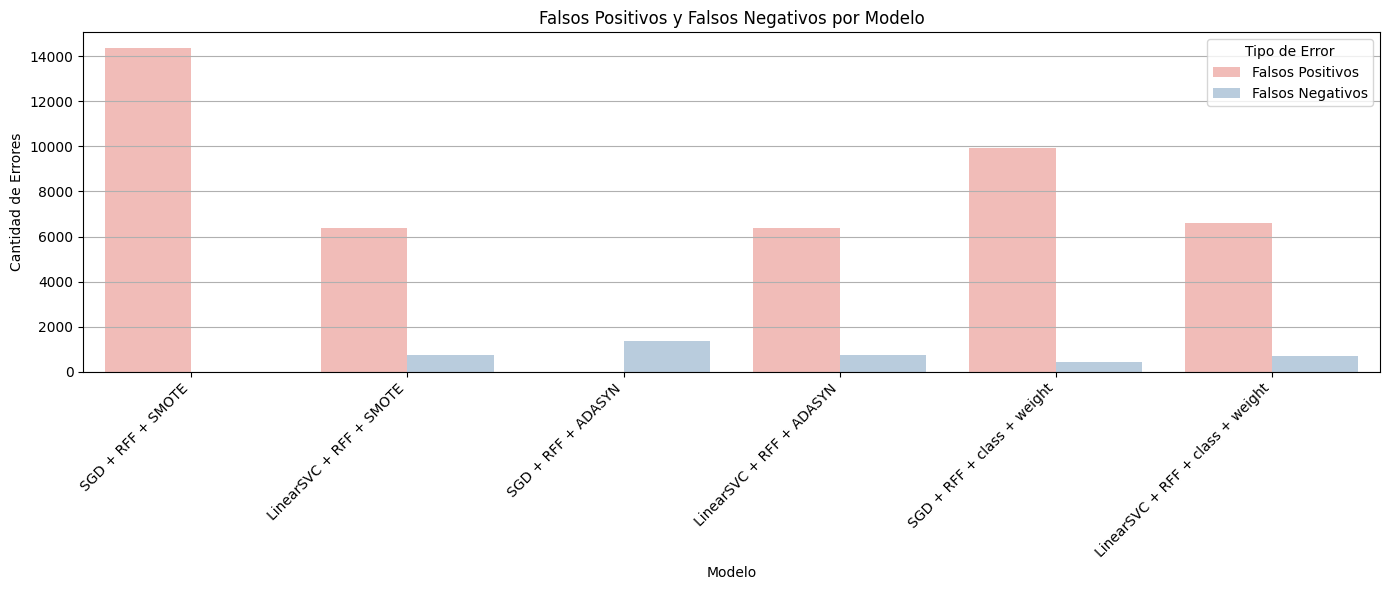

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

sns.barplot(data=df_fpfn_long, x="Modelo", y="Cantidad", hue="Tipo de Error", palette="Pastel1")

plt.title("Falsos Positivos y Falsos Negativos por Modelo")
plt.xlabel("Modelo")
plt.ylabel("Cantidad de Errores")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


# Curva de Aprendizaje

In [22]:
from sklearn.model_selection import learning_curve
import numpy as np

# Selecciona un pipeline para graficar la curva (ejemplo: uno de tus modelos)
modelo_base = pipelines["SGD_RFF_SMOTE"]

# Tamaños relativos del set de entrenamiento
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_base,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

# Promedios y desviaciones
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
test_mean  = test_scores.mean(axis=1)
test_std   = test_scores.std(axis=1)

# Construir DataFrame para seaborn
df_learning = pd.DataFrame({
    "Tamaño entrenamiento": np.concatenate([train_sizes, train_sizes]),
    "F1 Score": np.concatenate([train_mean, test_mean]),
    "Tipo": ["Entrenamiento"] * len(train_sizes) + ["Validación"] * len(train_sizes)
})


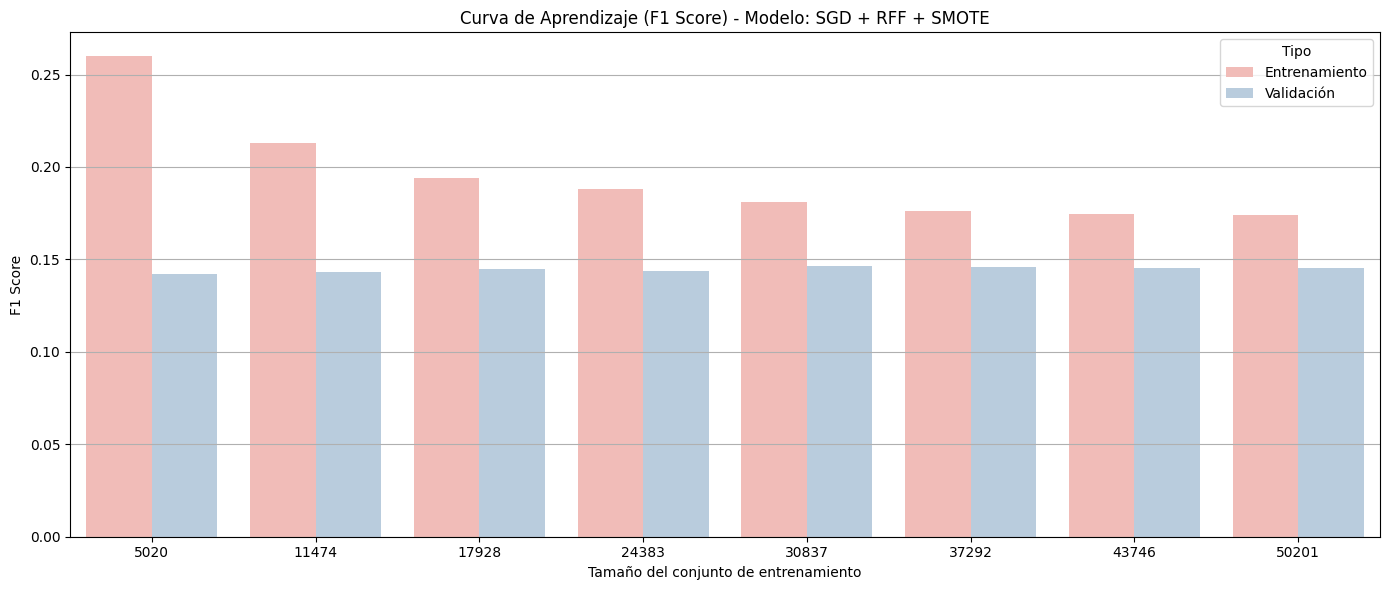

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

sns.barplot(
    data=df_learning,
    x="Tamaño entrenamiento",
    y="F1 Score",
    hue="Tipo",
    palette="Pastel1"
)

plt.title("Curva de Aprendizaje (F1 Score) - Modelo: SGD + RFF + SMOTE")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("F1 Score")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


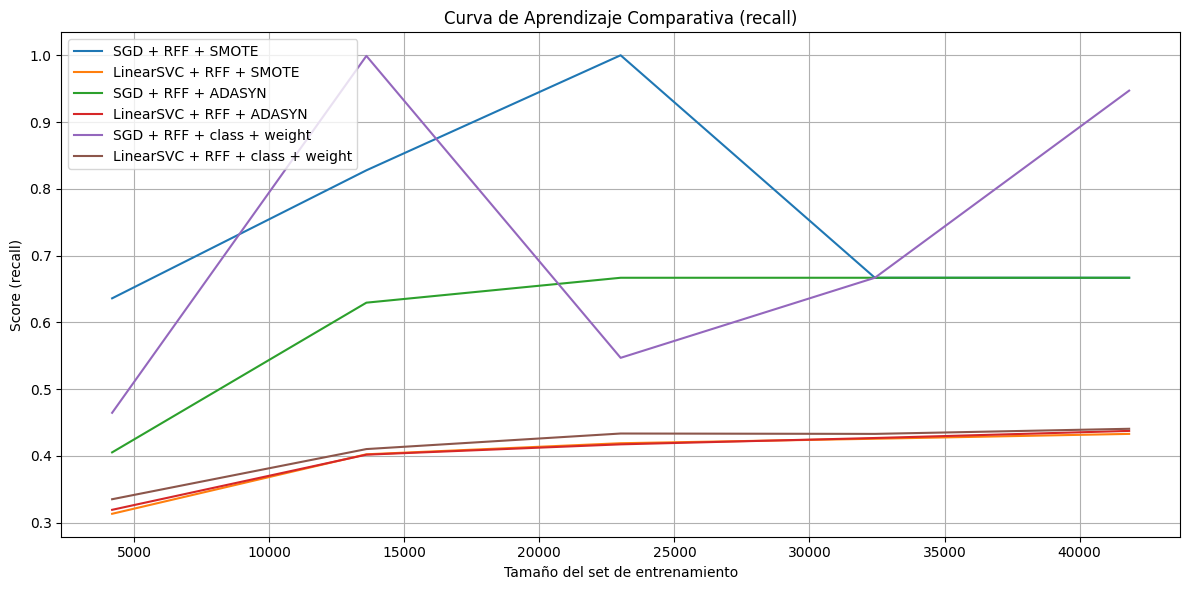

In [24]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Métrica de evaluación (puedes cambiarla por "accuracy", "f1", etc.)
scoring = "recall"

# Tamaños de entrenamiento a probar
train_sizes = np.linspace(0.1, 1.0, 5)

plt.figure(figsize=(12, 6))

# Comparar modelos entrenados
for nombre, modelo in modelos_entrenados.items():
    # Calcular curvas de aprendizaje
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator=modelo,
        X=X_train,
        y=y_train,
        train_sizes=train_sizes,
        cv=3,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    # Promedio de scores
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    # Graficar curva
    plt.plot(train_sizes_abs, val_mean, label=nombre.replace("_", " + "))

# Personalización
plt.title(f"Curva de Aprendizaje Comparativa ({scoring})")
plt.xlabel("Tamaño del set de entrenamiento")
plt.ylabel(f"Score ({scoring})")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


# Heatmap de Recall1 por Técnica

In [25]:
# Asegúrate de trabajar con una copia para no modificar el original
df_heat = df_resultados.copy()

# Extraer "Algoritmo" y "Técnica" desde el nombre del modelo (ej: "SGD_RFF_SMOTE")
df_heat["Algoritmo"] = df_heat["Modelo"].apply(lambda x: x.split("_")[0])
df_heat["Técnica"]   = df_heat["Modelo"].apply(lambda x: x.split("_")[-1])


In [26]:
# Crear tabla estilo matriz: filas = Técnica, columnas = Algoritmo, valores = Recall1
tabla_heatmap = df_heat.pivot_table(
    index="Técnica",
    columns="Algoritmo",
    values="Recall1"
)


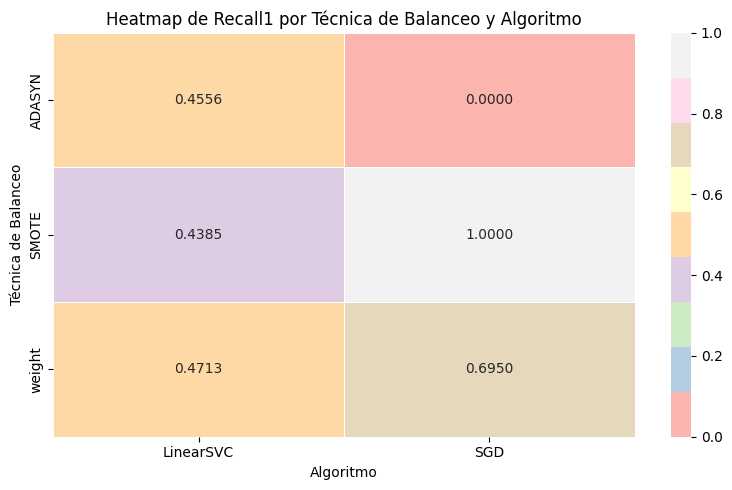

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

sns.heatmap(
    tabla_heatmap,
    annot=True,
    fmt=".4f",
    cmap="Pastel1",
    linewidths=0.5,
    linecolor="white"
)

plt.title("Heatmap de Recall1 por Técnica de Balanceo y Algoritmo")
plt.xlabel("Algoritmo")
plt.ylabel("Técnica de Balanceo")
plt.tight_layout()
plt.show()


# Radar Plot

In [28]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Seleccionar métricas a comparar
metricas = ["Precision", "Recall1", "F1", "Accuracy", "AUC"]

# Crear copia con solo métricas y modelo
df_radar = df_resultados[["Modelo"] + metricas].copy()

# Normalizar valores entre 0 y 1 para que encajen en la escala radial
scaler = MinMaxScaler()
df_radar[metricas] = scaler.fit_transform(df_radar[metricas])


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def radar_plot(df, model_names, metricas):
    # Ángulos para cada eje
    N = len(metricas)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el círculo

    # Inicializar gráfico
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)

    # Dibujar uno por uno
    for i, modelo in enumerate(model_names):
        valores = df.loc[df["Modelo"] == modelo, metricas].values.flatten().tolist()
        valores += valores[:1]  # Cerrar círculo
        ax.plot(angles, valores, label=modelo.replace("_", " + "), linewidth=2)
        ax.fill(angles, valores, alpha=0.1)

    # Etiquetas de cada métrica
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metricas)

    # Opciones estéticas
    ax.set_title("Radar Plot de Métricas por Modelo", size=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.set_rlabel_position(30)
    plt.tight_layout()
    plt.show()


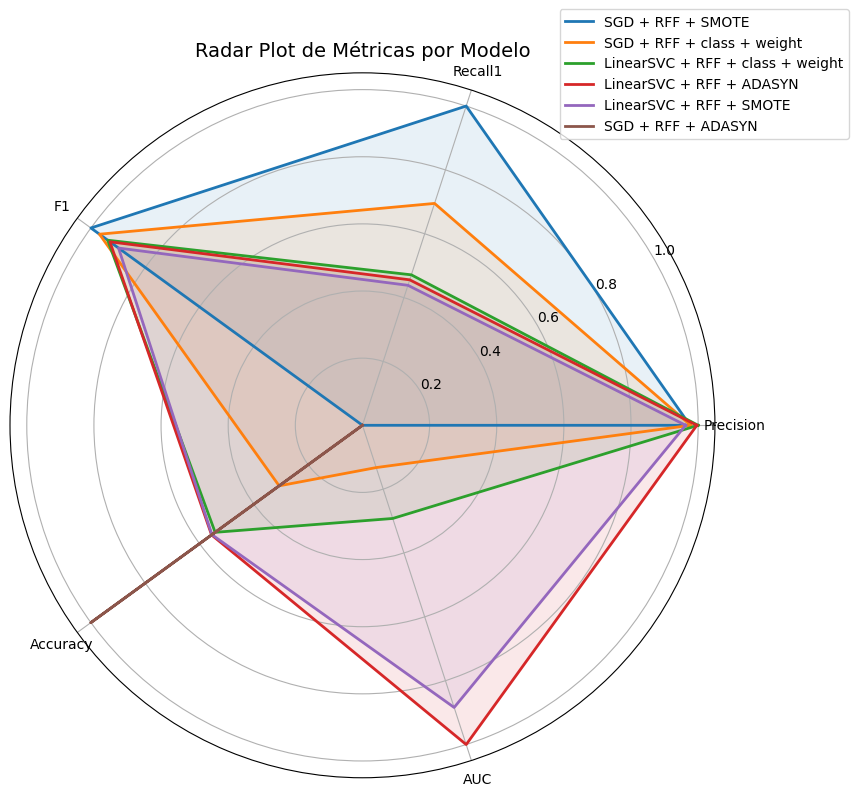

In [30]:
# Elegir algunos modelos para visualizar (máximo 3-5 idealmente para claridad)
modelos_a_comparar = df_radar["Modelo"].tolist()  # O selecciona a mano una lista

# Llamar función
radar_plot(df_radar, modelos_a_comparar, metricas)


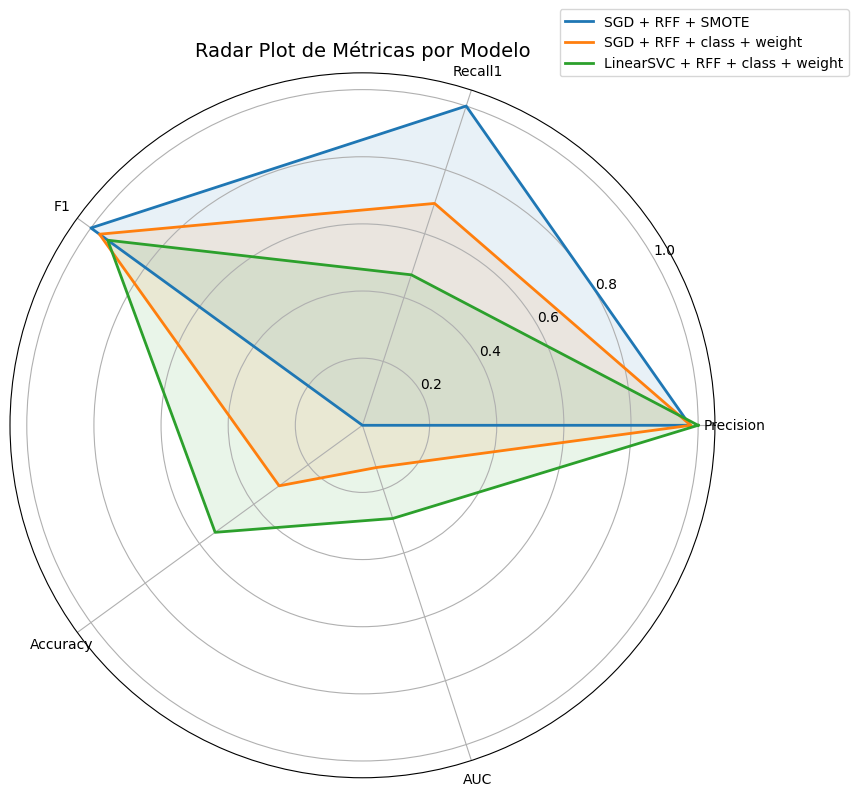

In [31]:
top3 = df_resultados.sort_values("Recall1", ascending=False).head(3)["Modelo"].tolist()
radar_plot(df_radar, top3, metricas)


# Hiperparametros optimos

In [32]:
# Expandir los parámetros en columnas separadas
df_hiper = pd.DataFrame(results)

# Expandir diccionario de hiperparámetros
parametros = df_hiper["Mejor Parámetro"].apply(pd.Series)

# Combinar con nombre de modelo
df_hiper = pd.concat([df_hiper[["Modelo"]], parametros], axis=1)


In [33]:
import seaborn as sns

# Paso 1: Eliminar columnas completamente vacías
df_hiper_limpio = df_hiper.dropna(axis=1, how='all')

# Paso 2: Eliminar columnas duplicadas (por nombre del paso alternativo)
# Si existe tanto 'clf__' como 'sgdclassifier__', eliminamos los segundos
cols_a_eliminar = [col for col in df_hiper_limpio.columns if col.startswith("sgdclassifier__")]
df_hiper_limpio = df_hiper_limpio.drop(columns=cols_a_eliminar)

# Paso 3: Aplicar estilo a la versión limpia
pastel_colors = sns.color_palette("Pastel1", n_colors=len(df_hiper_limpio.columns)-1)
styled = df_hiper_limpio.style

for col, color in zip(df_hiper_limpio.columns[1:], pastel_colors):
    styled = styled.set_properties(
        subset=[col],
        **{'background-color': f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 0.4)'}
    )

styled = styled.set_table_styles([
    {"selector": "th", "props": [("background-color", "#f3f3f3"), ("font-weight", "bold")]}
])

# Mostrar la tabla estilizada
display(styled)


,Modelo,clf__alpha,clf__early_stopping,clf__eta0,clf__l1_ratio,clf__learning_rate,clf__max_iter,clf__n_iter_no_change,clf__penalty,clf__validation_fraction,clf__C,clf__dual,clf__tol
0,SGD_RFF_SMOTE,0.010000,True,0.001000,0.300000,adaptive,1000,5.000000,elasticnet,0.100000,nan,nan,nan
1,LinearSVC_RFF_SMOTE,nan,nan,nan,nan,nan,2000,nan,nan,nan,0.100000,True,0.001000
2,SGD_RFF_ADASYN,0.010000,True,0.001000,0.150000,optimal,1000,5.000000,elasticnet,0.100000,nan,nan,nan
3,LinearSVC_RFF_ADASYN,nan,nan,nan,nan,nan,2000,nan,nan,nan,0.100000,True,0.001000
4,SGD_RFF_class_weight,0.010000,True,0.010000,0.150000,adaptive,1000,5.000000,l2,0.100000,nan,nan,nan
5,LinearSVC_RFF_class_weight,nan,nan,nan,nan,nan,2000,nan,nan,nan,10.000000,True,0.000100


# Guardar

In [34]:
import joblib
import os


In [35]:
# Crear carpeta para guardar modelos
os.makedirs("modelos_guardados", exist_ok=True)

# Guardar cada modelo en la carpeta
for nombre_modelo, modelo in modelos_entrenados.items():
    nombre_archivo = f"modelos_guardados/{nombre_modelo}.joblib"
    joblib.dump(modelo, nombre_archivo)
    print(f"✅ Modelo guardado: {nombre_archivo}")


✅ Modelo guardado: modelos_guardados/SGD_RFF_SMOTE.joblib
✅ Modelo guardado: modelos_guardados/LinearSVC_RFF_SMOTE.joblib
✅ Modelo guardado: modelos_guardados/SGD_RFF_ADASYN.joblib
✅ Modelo guardado: modelos_guardados/LinearSVC_RFF_ADASYN.joblib
✅ Modelo guardado: modelos_guardados/SGD_RFF_class_weight.joblib
✅ Modelo guardado: modelos_guardados/LinearSVC_RFF_class_weight.joblib
